In [1]:
import pennylane as qml
import random
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('../')

In [2]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [3]:
date = '20211014_151730'

resume_iters = 120

test_sample_size = 50

layer =1

z_dim = 8

In [4]:
model_dir_path = r'/home/ken/projects/QuantumGAN-PyTorch/results/GAN/'+date+'/train/model_dir'

In [5]:
def sample_z(batch_size):
    return np.random.normal(0, 1, size=(batch_size, z_dim))

In [6]:
z = sample_z(test_sample_size)

# Data

In [7]:
from data.sparse_molecular_dataset import SparseMolecularDataset

In [8]:
mol_data_dir = 'data/gdb9_9nodes.sparsedataset'

In [9]:
data = SparseMolecularDataset()

data.load(mol_data_dir)

# Generator

In [10]:
from models.models import Generator, Discriminator

In [11]:
complexity = 'nr'

dropout = 0.0

In [12]:
if complexity == 'nr':
    g_conv_dim = [128, 256, 512]
elif complexity == 'mr':
    g_conv_dim = [128]
elif complexity == 'hr':
    g_conv_dim = [16]
else:
    raise ValueError("Please enter an valid model complexity from 'mr', 'hr' or 'nr'!")

In [13]:
G = Generator(g_conv_dim, z_dim, data.vertexes, data.bond_num_types, data.atom_num_types, dropout)

In [14]:
G.to(device)

Generator(
  (activation_f): Tanh()
  (multi_dense_layers): MultiDenseLayers(
    (activation): Tanh()
    (linear_layers): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=256, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.0, inplace=False)
      (6): Linear(in_features=256, out_features=512, bias=True)
      (7): Tanh()
      (8): Dropout(p=0.0, inplace=False)
    )
  )
  (edges_layer): Linear(in_features=512, out_features=405, bias=True)
  (nodes_layer): Linear(in_features=512, out_features=45, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [15]:
G_path = os.path.join(model_dir_path, '{}-G.ckpt'.format(resume_iters))

In [16]:
G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))

<All keys matched successfully>

# Generating Molecules

In [17]:
import torch.nn.functional as F

In [18]:
z = torch.from_numpy(z).to(device).float()

In [19]:
post_method = 'softmax'

In [20]:
edges_logits, nodes_logits = G(z)

In [21]:
def postprocess(inputs, method, temperature=1.0):
    def listify(x):
        return x if type(x) == list or type(x) == tuple else [x]
    def delistify(x):
        return x if len(x) > 1 else x[0]
    if method == 'soft_gumbel':
        softmax = [F.gumbel_softmax(e_logits.contiguous().view(-1, e_logits.size(-1))/temperature, hard=False).view(e_logits.size()) for e_logits in listify(inputs)]
    elif method == 'hard_gumbel':
        softmax = [F.gumbel_softmax(e_logits.contiguous().view(-1, e_logits.size(-1))/temperature, hard=True).view(e_logits.size()) for e_logits in listify(inputs)]
    else:
        softmax = [F.softmax(e_logits/temperature, -1) for e_logits in listify(inputs)]
    return [delistify(e) for e in (softmax)]

In [22]:
(edges_hat, nodes_hat) = postprocess((edges_logits, nodes_logits), post_method)   

edges_hat_numpy = edges_hat.cpu().detach().numpy()
nodes_hat_numpy = nodes_hat.cpu().detach().numpy()
np.save("edges_hat.npy", edges_hat_numpy)
np.save("nodes_hat.npy", nodes_hat_numpy)

In [23]:
def get_gen_mols(data, n_hat, e_hat, method):
    (edges_hard, nodes_hard) = postprocess((e_hat, n_hat), method)
    edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
    mols = [data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True) for e_, n_ in zip(edges_hard, nodes_hard)]
    return mols

In [24]:
mols = get_gen_mols(data, nodes_logits, edges_logits, post_method)

RDKit ERROR: [17:33:54] Explicit valence for atom # 1 O, 3, is greater than permitted
[17:33:54] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [17:33:54] non-ring atom 0 marked aromatic
[17:33:54] non-ring atom 0 marked aromatic
RDKit ERROR: [17:33:54] Can't kekulize mol.  Unkekulized atoms: 1 6 8
RDKit ERROR: 
RDKit ERROR: [17:33:54] Can't kekulize mol.  Unkekulized atoms: 1 2 8
[17:33:54] Can't kekulize mol.  Unkekulized atoms: 1 6 8

[17:33:54] Can't kekulize mol.  Unkekulized atoms: 1 2 8

RDKit ERROR: 
RDKit ERROR: [17:33:54] Explicit valence for atom # 4 N, 4, is greater than permitted
[17:33:54] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [17:33:54] Explicit valence for atom # 7 F, 2, is greater than permitted
[17:33:54] Explicit valence for atom # 7 F, 2, is greater than permitted
RDKit ERROR: [17:33:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 8
[17:33:54] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6

# Scores

In [25]:
from utils.utils import *

In [26]:
m0, m1 = all_scores(mols, data, norm=True)

In [27]:
data = m0['drugcand']
data_avg = sum(data)/len(data)
data_std = np.std(data)

Text(0.5, 7, 'mean: 0.41, std: 0.18')

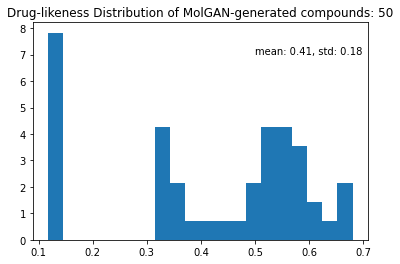

In [28]:
plt.hist(data, bins=20, density=True)
plt.title('Drug-likeness Distribution of MolGAN-generated compounds: {}'.format(test_sample_size))
plt.text(0.5, 7, 'mean: {:.2f}, std: {:.2f}'.format(data_avg, data_std))

In [29]:
from collections import defaultdict

scores = defaultdict(list)

for k, v in m1.items():
    scores[k].append(v)
for k, v in m0.items():
    scores[k].append(np.array(v)[np.nonzero(v)].mean())

In [30]:
scores

defaultdict(list,
            {'valid': [77.99999713897705],
             'unique': [100.0],
             'novel': [74.35897435897436],
             'NP': [0.9145675207475009],
             'QED': [0.46482954250809644],
             'Solute': [0.32707430083894345],
             'SA': [0.28397694920955857],
             'diverse': [0.7099268861770189],
             'drugcand': [0.4140894658788428]})

In [31]:
v = MolecularMetrics.valid_filter(mols)

In [32]:
s = set(map(lambda x: Chem.MolToSmiles(x), v))

In [33]:
print(len(s))

39


In [34]:
from rdkit.Chem import Draw

unique_mols = list(map(lambda x: Chem.MolFromSmiles(x), s))

In [35]:
img=Draw.MolsToGridImage(unique_mols[3000:],molsPerRow=8,subImgSize=(200,200), maxMols=500)    

In [36]:
img

df = pd.DataFrame({'SMILES': data} for data in s)

df.to_csv('molgan-'+str(resume_iters)+'.csv', index=False)